In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

In [2]:
from datasets import (
    Puerto_Rico_Building_Dataset, 
    Cloud_DrivenData_Dataset,
    OpenCities_Building_Dataset
)

In [4]:
from pathlib import Path
DATA_DIR = Path.cwd().parent.resolve() / "data/data_samples/Cloud_DrivenData/final/public"
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"
TRAIN_META_FILE = DATA_DIR / "train_metadata.csv"
BANDS = ["B04", "B03", "B02"] #"B08"
assert TRAIN_FEATURES.exists()
assert TRAIN_META_FILE.exists()

import pandas as pd
train_meta = pd.read_csv(TRAIN_META_FILE)

from pathlib import Path
import pandas as pd

def add_paths(df: pd.DataFrame, feature_dir: Path, label_dir: Path = None, bands: list = BANDS) -> pd.DataFrame:
    """
    Adds file paths for each band and label to the dataframe based on chip_id.
    
    Args:
        df (pd.DataFrame): DataFrame containing chip_id (e.g., image identifiers).
        feature_dir (Path): Directory where feature TIF images are stored.
        label_dir (Path, optional): Directory where label TIF images are stored. Defaults to None.
        bands (list): List of band names (e.g., ["B02", "B03", ...]). Defaults to BANDS.
        
    Returns:
        pd.DataFrame: Updated dataframe with new columns for each band path and label path.
    
    Adds the following columns to the dataframe:
        - "{band}_path" for each band image.
        - "label_path" for the label image, if `label_dir` is provided.
        - "has_{band}_path" boolean column indicating if the feature file exists.
        - "has_image_channels" boolean column indicating if all feature band files exist.
        - "has_label_path" boolean column indicating if the label file exists (if `label_dir` is provided).
        - "accessible" boolean column indicating if all image channels and label file exist.
    """
    # Ensure feature_dir and label_dir are Path objects
    feature_dir = Path(feature_dir)
    if label_dir is not None:
        label_dir = Path(label_dir)

    selected_columns = ["chip_id", "location", "datetime", 
                        "cloudpath"
                        ]
    
    # Initialize columns to track file existence for each band
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        # Check if the band file exists and add a boolean column
        df[f"has_{band}_path"] = df[f"{band}_path"].apply(lambda x: x.exists())
        selected_columns.append(f"{band}_path")

    # Add "has_image_channels" to check if all bands exist
    df["has_image_channels"] = df[[f"has_{band}_path" for band in bands]].all(axis=1)
    # Add label path and check existence if label_dir is provided
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")   
        # Check if the label file exists and add a boolean column
        df["has_label_path"] = df["label_path"].apply(lambda x: x.exists())
        selected_columns.append("label_path")
    
    # Add "accessible" column to check if all bands and label file exist
    df["accessible"] = df["has_image_channels"] & df["has_label_path"]
    
    return df[df["accessible"] == True][selected_columns]

train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)

#################
import random
random.seed(9)  # set a seed for reproducibility

# put 1/3 of chips into the validation set
chip_ids = train_meta.chip_id.unique().tolist()
val_chip_ids = random.sample(chip_ids, round(len(chip_ids) * 0.2))

val_mask = train_meta.chip_id.isin(val_chip_ids)
val = train_meta[val_mask].copy().reset_index(drop=True)
train = train_meta[~val_mask].copy().reset_index(drop=True)

val.shape, train.shape
#################
# separate features from labels
feature_cols = ["chip_id"] + [f"{band}_path" for band in BANDS]

train_x = train[feature_cols].copy()
train_y = train[["chip_id", "label_path"]].copy()

val_x = val[feature_cols].copy()
val_y = val[["chip_id", "label_path"]].copy()

### Test Data Augmentation (Tested)

In [3]:
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

In [4]:
segmentation_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),  # Random horizontal flip with 50% probability
        A.VerticalFlip(p=0.5),    # Random vertical flip with 50% probability
        A.RandomRotate90(p=0.5),  # Random 90 degree rotation with 50% probability
        A.ShiftScaleRotate(
            shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5, border_mode=0
        ),  # Random shift, scale, and rotation with fill at borders
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),  # Adjust color properties
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),  # Adjust brightness and contrast
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),  # Apply a Gaussian blur
        A.GaussNoise(var_limit=(10, 50), p=0.3),  # Add Gaussian noise
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize to standard values
        ToTensorV2(),  # Convert to PyTorch tensors
    ]
)

In [7]:
data = Cloud_DrivenData_Dataset(
        x_paths= train_x,
        bands = BANDS,
        y_paths = train_y,
        transform = segmentation_transform,
        pytorch=False
)

In [9]:
import numpy as np
import copy
import matplotlib.pyplot as plt 
import torch

def show_images(original : np.array, augmented : np.array):
    """Display the original and augmented images."""
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original)
    axs[0].set_title("Original Image")
    axs[1].imshow(augmented)
    axs[1].set_title("Augmented Image")

def show_mask(original : np.array, augmented : np.array):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original)
    axs[0].set_title("Original Mask")
    axs[1].imshow(augmented)
    axs[1].set_title("Augmented Mask")


In [ ]:
data_puerto = Puerto_Rico_Building_Dataset(
    base_dir="../data/data_samples/Puerto_Rico_dataset/",
    pre_disaster_dir="Pre_Event_Grids_In_TIFF",
    post_disaster_dir="Post_Event_Grids_In_TIFF",
    mask_dir="Grids_In_TIFF_mask",
    transform=segmentation_transform,
    )


In [6]:
inputs = data_puerto[0]

In [2]:
from datasets import  OpenCities_Building_Dataset

base_dir = "../data/data_samples/Open-cities/training_data"
image_dir = f'{base_dir}/images'
mask_dir = f'{base_dir}/masks'


data = OpenCities_Building_Dataset(
    images_dir=image_dir,
    masks_dir=mask_dir
)

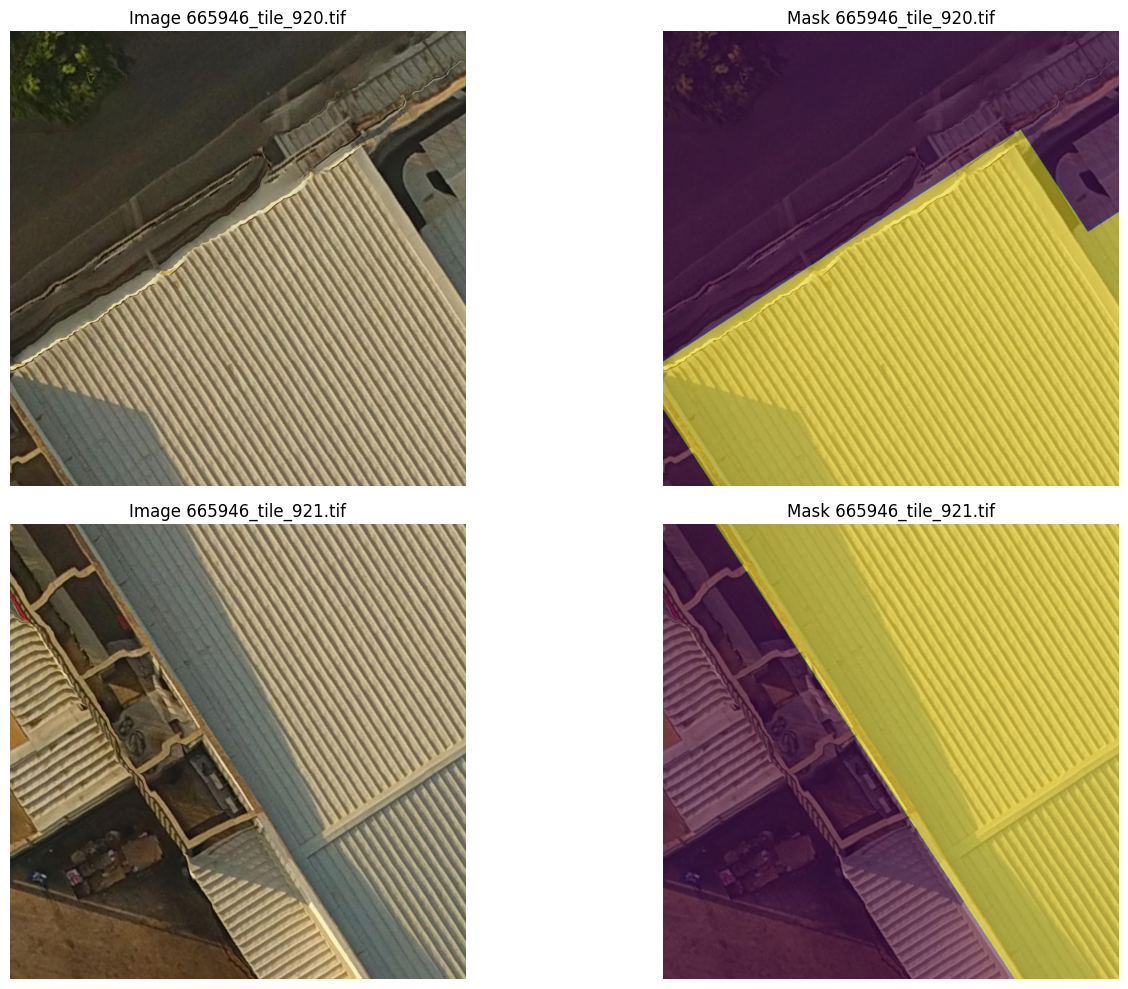

In [4]:
data.display_data(list_indices=[0,1])